# Imports 

In [1]:
from pythae.models.ae import AE, AEConfig
from pythae.models.base.base_utils import ModelOutput
from mlae.model.mlae import MaximumLikelihoodAutoencoder, MLAEHParams
from mlae.model.conv_auto_encoder import ConvAutoEncoder, ConvAutoEncoderHParams
from mlae.model.utils import guess_image_shape
from mlae.data.image import get_celeba_datasets, get_cifar10_datasets, get_mnist_datasets
from pythae.models import WAE_MMD, WAE_MMD_Config
from torch import nn
from pythae.models.nn.base_architectures import BaseDecoder, BaseEncoder
from pythae.models.base.base_utils import ModelOutput
from pythae.pipelines import TrainingPipeline
from pythae.trainers import BaseTrainerConfig
from pythae.samplers import NormalSampler, GaussianMixtureSampler


from pythae.models.nn.benchmarks.mnist import Encoder_Conv_AE_MNIST
from pythae.models.nn.benchmarks.mnist import Decoder_Conv_AE_MNIST
from pythae.models.nn.benchmarks.mnist import Encoder_ResNet_AE_MNIST
from pythae.models.nn.benchmarks.mnist import Decoder_ResNet_AE_MNIST

from pythae.models.nn.benchmarks.celeba import Encoder_Conv_AE_CELEBA
from pythae.models.nn.benchmarks.celeba import Decoder_Conv_AE_CELEBA
from pythae.models.nn.benchmarks.celeba import Encoder_ResNet_AE_CELEBA
from pythae.models.nn.benchmarks.celeba import Decoder_ResNet_AE_CELEBA

from pythae.models.nn.benchmarks.cifar import Encoder_Conv_AE_CIFAR
from pythae.models.nn.benchmarks.cifar import Decoder_Conv_AE_CIFAR
from pythae.models.nn.benchmarks.cifar import Encoder_ResNet_AE_CIFAR
from pythae.models.nn.benchmarks.cifar import Decoder_ResNet_AE_CIFAR

import os
import pythae
import numpy as np
from collections import OrderedDict
from pydantic.dataclasses import dataclass
import torch
from math import ceil
import json

In [2]:
import uuid
random_hex = uuid.uuid4().hex[:4]

# MLAE to PythAE model

In [3]:
class UnwrapOutput(torch.nn.Module):
    def forward(self,output):
        if "embedding" in output.keys():
            return output["embedding"].squeeze()
        elif "reconstruction" in output.keys():
            return output["reconstruction"].squeeze()
        else:
            return output.squeeze()
        
class AddBatchDim(torch.nn.Module):
    def __init__(self, target_dim):
        super().__init__()
        self.target_dim = target_dim
        
    def forward(self, output):
        if output.ndim == self.target_dim:
            return output
        elif output.ndim == self.target_dim-1:
            return output[None,...]
        else:
            raise(ValueError(f"Expected {self.target_dim}D or {self.target_dim-1}D input but got {output.ndim}D"))
    
def build_MLAE_model_from_pythAE(pythAE_model):
    hparams = ConvAutoEncoderHParams(latent_dim=pythAE_model.model_config.latent_dim,
                                 data_dim=int(np.prod(pythAE_model.input_dim)),
                                 cond_dim=0)
    input_shape = pythAE_model.input_dim
    try:
        MLAE_model = ConvAutoEncoder(hparams)
    except ValueError:
        try:
            # If decoder output shape of MLAE does not match on initialization, temporarily set it
            hparams["decoder_spec"] = [
              [ 8, 8 ],
              [ 4, 5, 2, 2 ],
              [ 2, 5, 2, 1 ],
              [ 1, 5, 2, 2, 1 ],
              [ 3, 5, 1, 1 ],
            ]
            MLAE_model = ConvAutoEncoder(hparams)
        except ValueError:
            hparams["decoder_spec"] = [
              [ 8, 8 ],
              [ 4, 5, 2, 2 ],
              [ 1, 5, 2, 2, 1 ],
              [ 3, 5, 1, 1 ],
            ]
        MLAE_model = ConvAutoEncoder(hparams)
    # Overwrite MLAE networks
    encoder = nn.Sequential(nn.Unflatten(-1, (input_shape[0], *input_shape[1:])),
                            AddBatchDim(4),
                            pythAE_model.encoder, 
                            UnwrapOutput())
    decoder = nn.Sequential(pythAE_model.decoder, 
                            UnwrapOutput(),
                            nn.Flatten())
    MLAE_model.model = nn.Sequential(OrderedDict(encoder=encoder, decoder=decoder))
    return MLAE_model

class MLAE(AE):
    def __init__(self, model_config, encoder = None, decoder = None, batch_size=512):
        AE.__init__(self, model_config=model_config, encoder=encoder, decoder=decoder)
        self.model_name = "MLAE"
        self.model_config = model_config
        self.MLAE_hparams = model_config.to_MLAE_params([build_MLAE_model_from_pythAE(self)])
        self.MLAE_model = MaximumLikelihoodAutoencoder(self.MLAE_hparams)
        self.train_batch_idx = 0
        self.val_batch_idx = 0
        self.epoch = 1
        
    def forward(self, inputs, epoch=0, dataset_size=60_000, **kwargs):
        if not epoch == self.epoch:
            self.epoch = epoch
            self.train_batch_idx = 0
            self.val_batch_idx = 0
            
        if self.training:
            batch_idx = self.train_batch_idx
            self.train_batch_idx += 1
        else:
            batch_idx = self.val_batch_idx
            self.val_batch_idx += 1

        x = inputs["data"]
        x = x.reshape(x.shape[0], -1)
        if not self.training:
            metrics = self.MLAE_model.compute_metrics((x,), batch_idx)
            _, x, _, c = self.MLAE_model.apply_conditions((x,))
            metrics["z"] = self.MLAE_model.encode(x, c)
            metrics["recon_x"] = self.MLAE_model.decode(metrics["z"], c)
        else:
            metrics = self.MLAE_model.compute_metrics((x,), batch_idx)
        output = ModelOutput(**metrics)
        return output
        
    

In [4]:
@dataclass(kw_only=True)
class MLAEConfig(AEConfig):
    loss_weights: dict
    log_det_estimator: dict
    batch_size: int
    max_epochs: int
    data_set: dict
    warm_up_epochs: int | list = 0
    noise: float | list = 0.01
    skip_val_nll: bool | int = False
        
    def to_MLAE_params(self, models):
        return MLAEHParams(models=models, 
                          loss_weights=self.loss_weights, 
                          warm_up_epochs=self.warm_up_epochs, 
                          noise=self.noise,
                          log_det_estimator=self.log_det_estimator,
                          batch_size=self.batch_size,
                          max_epochs=self.max_epochs,
                          data_set=self.data_set,
                          skip_val_nll=self.skip_val_nll,
                         )

# Copy of the PythAE benchmark training

In [5]:
from torch.utils.data import Dataset


class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self


class DictDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, i):
        return AttrDict({
            "data": self.dataset[i]
        })

In [6]:
def train_benchmark(dataset, model_params, training_config, architecture):
    train_data, eval_data = map(DictDataset, dataset)
    data_shape = train_data[0]["data"].shape

    model_config = MLAEConfig.from_dict(model_params)
    model_config.input_dim = tuple(data_shape)


    callbacks = []
    training_config = BaseTrainerConfig.from_json_file(training_config)
    model = MLAE(model_config=model_config, 
                 encoder=architecture["encoder"](model_config), 
                 decoder=architecture["decoder"](model_config),
                 batch_size=training_config.per_device_train_batch_size)
    pipeline = TrainingPipeline(training_config=training_config, model=model)
    trainer = pipeline(train_data=train_data, eval_data=eval_data, callbacks=callbacks)
    return model, trainer.training_dir

# Settings for benchmark run

In [7]:
USE_RESNET = True
# PythAE training script (not the benchmark default)
USE_PYTHAE_TRAINING_SCRIPT = False
PYTHAE_SCRIPT_PATH = os.path.join("/", *pythae.__file__.split("/")[:-3], "examples", "scripts")
DATASET_NAME = "celeba"
MODEL_PARAMS = {
    "latent_dim": 64, # PythAE default
    "loss_weights": {"nll": 1, "noisy_reconstruction": 15}, # MLAE default
    "skip_val_nll": 1,
    # "warm_up_epochs": [105, 0], # not used for benchmark
    "log_det_estimator": { # MLAE default
      "name": "surrogate", 
      "hutchinson_samples": 1,
    },
    "noise": 1.e-2, # MLAE default
    
    # Dummy parameters for Lightning_trainable. They have no effect!
    "batch_size": 512,
    "max_epochs": 100,
    "data_set": {
      "name": DATASET_NAME,
      "root": "pythae_benchmarks/",
      "load_to_memory": True,
    },
}
# if not using PythAE default training
CUSTOM_TRAINING_CONFIG = {
  "name": "BaseTrainerConfig", # PythAE default
  "output_dir": "pythae_benchmarks",
  "per_device_train_batch_size": 100, # PythAE default. This is the correct parameter name
  "per_device_eval_batch_size": 100, # PythAE default. This is the correct parameter name
  "optimizer_params": {"weight_decay": 0.0}, # PythAE default
  "num_epochs": 50, # PythAE default for CelebA
  "learning_rate": 1.e-4, # PythAE default
  "steps_saving": None, # PythAE default
  "steps_predict": None, # PythAE default
  "no_cuda": False, # PythAE default
  "scheduler_cls": "ReduceLROnPlateau", # PythAE default
  "scheduler_params": {"factor": 0.5}, # PythAE default
}

if USE_RESNET:
    if DATASET_NAME == "mnist":
        architecture = {"encoder": Encoder_ResNet_AE_MNIST, "decoder": Decoder_ResNet_AE_MNIST}
    elif DATASET_NAME == "celeba": 
        architecture = {"encoder": Encoder_ResNet_AE_CELEBA, "decoder": Decoder_ResNet_AE_CELEBA}
    elif DATASET_NAME == "cifar10": 
        architecture = {"encoder": Encoder_ResNet_AE_CIFAR, "decoder": Decoder_ResNet_AE_CIFAR}        
else:
    if DATASET_NAME == "mnist":
        architecture = {"encoder": Encoder_Conv_AE_MNIST, "decoder": Decoder_Conv_AE_MNIST}
    elif DATASET_NAME == "celeba": 
        architecture = {"encoder": Encoder_Conv_AE_CELEBA, "decoder": Decoder_Conv_AE_CELEBA}
    elif DATASET_NAME == "celeba": 
        architecture = {"encoder": Encoder_Conv_AE_CIFAR, "decoder": Decoder_Conv_AE_CIFAR}
    
if not os.path.exists("pythae_benchmarks"):
    os.mkdir("pythae_benchmarks")

if USE_PYTHAE_TRAINING_SCRIPT:
    training_config_path = os.path.join("/", *(PYTHAE_SCRIPT_PATH.split("/")), f"configs/{DATASET_NAME}/base_training_config.json")
else:
    training_config_path = os.path.join("pythae_benchmarks", f"custom_training_config_{random_hex}.json")

    with open(training_config_path, "w") as f:
        json.dump(CUSTOM_TRAINING_CONFIG, f)

# Training

In [8]:
MLAE_datapath = os.path.join("pythae_benchmarks")


if DATASET_NAME == "mnist":
    train_set, val_set, _ = get_mnist_datasets(MLAE_datapath)
    train_set, val_set = train_set.tensors[0].reshape(-1, 1, 28, 28), val_set.tensors[0].reshape(-1, 1, 28, 28)
elif DATASET_NAME == "celeba":
    train_set, val_set, _ = get_celeba_datasets(MLAE_datapath, load_to_memory=True)
    train_set = torch.stack([x[0].reshape(3, 64, 64) for x in train_set], dim=0)
    val_set = torch.stack([x[0].reshape(3, 64, 64) for x in val_set], dim=0)
elif DATASET_NAME == "cifar10":
    train_set, val_set, _ = get_cifar10_datasets(MLAE_datapath)
    train_set = train_set.tensors[0].reshape(-1, 3, 32, 32)
    val_set = val_set.tensors[0].reshape(-1, 3, 32, 32)

In [9]:
model, model_dir = train_benchmark((train_set, val_set), MODEL_PARAMS, training_config_path, architecture)

Checking train dataset...
Checking eval dataset...
Using Base Trainer

/home/armand/miniconda3/lib/python3.10/site-packages/lightning/pytorch/core/module.py:410: UserWarning: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`
  rank_zero_warn(
Model passed sanity check !
Ready for training.

Created pythae_benchmarks/MLAE_training_2023-06-14_16-11-46_d31b. 
Training config, checkpoints and final model will be saved here.

Training params:
 - max_epochs: 50
 - per_device_train_batch_size: 100
 - per_device_eval_batch_size: 100
 - checkpoint saving every: None
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0.0
)
Scheduler: <torch.optim.lr_scheduler.ReduceLROnPlateau object at 0x7f527edeab

Training of epoch 1/50:   0%|          | 0/1628 [00:00<?, ?batch/s]

Eval of epoch 1/50:   0%|          | 0/199 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 3161.8797
Eval loss: 1794.763
--------------------------------------------------------------------------


Training of epoch 2/50:   0%|          | 0/1628 [00:00<?, ?batch/s]

Eval of epoch 2/50:   0%|          | 0/199 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 1637.0364
Eval loss: 1492.052
--------------------------------------------------------------------------


Training of epoch 3/50:   0%|          | 0/1628 [00:00<?, ?batch/s]

Eval of epoch 3/50:   0%|          | 0/199 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 1469.3135
Eval loss: 1404.0715
--------------------------------------------------------------------------


Training of epoch 4/50:   0%|          | 0/1628 [00:00<?, ?batch/s]

Eval of epoch 4/50:   0%|          | 0/199 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 1402.0763
Eval loss: 1342.1265
--------------------------------------------------------------------------


Training of epoch 5/50:   0%|          | 0/1628 [00:00<?, ?batch/s]

Eval of epoch 5/50:   0%|          | 0/199 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 1359.3094
Eval loss: 1305.0189
--------------------------------------------------------------------------


Training of epoch 6/50:   0%|          | 0/1628 [00:00<?, ?batch/s]

Eval of epoch 6/50:   0%|          | 0/199 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 1328.4076
Eval loss: 1283.1646
--------------------------------------------------------------------------


Training of epoch 7/50:   0%|          | 0/1628 [00:00<?, ?batch/s]

Eval of epoch 7/50:   0%|          | 0/199 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 1305.3846
Eval loss: 1263.5354
--------------------------------------------------------------------------


Training of epoch 8/50:   0%|          | 0/1628 [00:00<?, ?batch/s]

Eval of epoch 8/50:   0%|          | 0/199 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 1285.6149
Eval loss: 1244.5234
--------------------------------------------------------------------------


Training of epoch 9/50:   0%|          | 0/1628 [00:00<?, ?batch/s]

Eval of epoch 9/50:   0%|          | 0/199 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 1269.8518
Eval loss: 1231.5257
--------------------------------------------------------------------------


Training of epoch 10/50:   0%|          | 0/1628 [00:00<?, ?batch/s]

Eval of epoch 10/50:   0%|          | 0/199 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 1256.5989
Eval loss: 1217.8213
--------------------------------------------------------------------------


Training of epoch 11/50:   0%|          | 0/1628 [00:00<?, ?batch/s]

Eval of epoch 11/50:   0%|          | 0/199 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 1244.9986
Eval loss: 1208.4677
--------------------------------------------------------------------------


Training of epoch 12/50:   0%|          | 0/1628 [00:00<?, ?batch/s]

Eval of epoch 12/50:   0%|          | 0/199 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 1233.9796
Eval loss: 1206.9702
--------------------------------------------------------------------------


Training of epoch 13/50:   0%|          | 0/1628 [00:00<?, ?batch/s]

Eval of epoch 13/50:   0%|          | 0/199 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 1224.4557
Eval loss: 1196.0143
--------------------------------------------------------------------------


Training of epoch 14/50:   0%|          | 0/1628 [00:00<?, ?batch/s]

Eval of epoch 14/50:   0%|          | 0/199 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 1214.9561
Eval loss: 1183.5425
--------------------------------------------------------------------------


Training of epoch 15/50:   0%|          | 0/1628 [00:00<?, ?batch/s]

Eval of epoch 15/50:   0%|          | 0/199 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 1205.2027
Eval loss: 1172.4286
--------------------------------------------------------------------------


Training of epoch 16/50:   0%|          | 0/1628 [00:00<?, ?batch/s]

Eval of epoch 16/50:   0%|          | 0/199 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 1193.7636
Eval loss: 1161.1567
--------------------------------------------------------------------------


Training of epoch 17/50:   0%|          | 0/1628 [00:00<?, ?batch/s]

Eval of epoch 17/50:   0%|          | 0/199 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 1183.6129
Eval loss: 1156.0933
--------------------------------------------------------------------------


Training of epoch 18/50:   0%|          | 0/1628 [00:00<?, ?batch/s]

Eval of epoch 18/50:   0%|          | 0/199 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 1174.9857
Eval loss: 1144.7845
--------------------------------------------------------------------------


Training of epoch 19/50:   0%|          | 0/1628 [00:00<?, ?batch/s]

Eval of epoch 19/50:   0%|          | 0/199 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 1167.4247
Eval loss: 1143.905
--------------------------------------------------------------------------


Training of epoch 20/50:   0%|          | 0/1628 [00:00<?, ?batch/s]

Eval of epoch 20/50:   0%|          | 0/199 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 1160.7818
Eval loss: 1132.5329
--------------------------------------------------------------------------


Training of epoch 21/50:   0%|          | 0/1628 [00:00<?, ?batch/s]

Eval of epoch 21/50:   0%|          | 0/199 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 1154.399
Eval loss: 1126.9192
--------------------------------------------------------------------------


Training of epoch 22/50:   0%|          | 0/1628 [00:00<?, ?batch/s]

Eval of epoch 22/50:   0%|          | 0/199 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 1148.499
Eval loss: 1131.3926
--------------------------------------------------------------------------


Training of epoch 23/50:   0%|          | 0/1628 [00:00<?, ?batch/s]

Eval of epoch 23/50:   0%|          | 0/199 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 1143.2223
Eval loss: 1118.9459
--------------------------------------------------------------------------


Training of epoch 24/50:   0%|          | 0/1628 [00:00<?, ?batch/s]

Eval of epoch 24/50:   0%|          | 0/199 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 1138.6206
Eval loss: 1113.0502
--------------------------------------------------------------------------


Training of epoch 25/50:   0%|          | 0/1628 [00:00<?, ?batch/s]

Eval of epoch 25/50:   0%|          | 0/199 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 1133.5169
Eval loss: 1108.1974
--------------------------------------------------------------------------


Training of epoch 26/50:   0%|          | 0/1628 [00:00<?, ?batch/s]

Eval of epoch 26/50:   0%|          | 0/199 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 1129.6591
Eval loss: 1107.6428
--------------------------------------------------------------------------


Training of epoch 27/50:   0%|          | 0/1628 [00:00<?, ?batch/s]

Eval of epoch 27/50:   0%|          | 0/199 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 1125.0499
Eval loss: 1103.8577
--------------------------------------------------------------------------


Training of epoch 28/50:   0%|          | 0/1628 [00:00<?, ?batch/s]

Eval of epoch 28/50:   0%|          | 0/199 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 1121.4573
Eval loss: 1098.4476
--------------------------------------------------------------------------


Training of epoch 29/50:   0%|          | 0/1628 [00:00<?, ?batch/s]

Eval of epoch 29/50:   0%|          | 0/199 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 1117.7535
Eval loss: 1097.1817
--------------------------------------------------------------------------


Training of epoch 30/50:   0%|          | 0/1628 [00:00<?, ?batch/s]

Eval of epoch 30/50:   0%|          | 0/199 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 1114.3799
Eval loss: 1091.3096
--------------------------------------------------------------------------


Training of epoch 31/50:   0%|          | 0/1628 [00:00<?, ?batch/s]

Eval of epoch 31/50:   0%|          | 0/199 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 1110.6095
Eval loss: 1091.55
--------------------------------------------------------------------------


Training of epoch 32/50:   0%|          | 0/1628 [00:00<?, ?batch/s]

Eval of epoch 32/50:   0%|          | 0/199 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 1107.5137
Eval loss: 1092.5982
--------------------------------------------------------------------------


Training of epoch 33/50:   0%|          | 0/1628 [00:00<?, ?batch/s]

Eval of epoch 33/50:   0%|          | 0/199 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 1104.6319
Eval loss: 1086.8173
--------------------------------------------------------------------------


Training of epoch 34/50:   0%|          | 0/1628 [00:00<?, ?batch/s]

Eval of epoch 34/50:   0%|          | 0/199 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 1101.7197
Eval loss: 1084.7303
--------------------------------------------------------------------------


Training of epoch 35/50:   0%|          | 0/1628 [00:00<?, ?batch/s]

Eval of epoch 35/50:   0%|          | 0/199 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 1098.8195
Eval loss: 1080.5113
--------------------------------------------------------------------------


Training of epoch 36/50:   0%|          | 0/1628 [00:00<?, ?batch/s]

Eval of epoch 36/50:   0%|          | 0/199 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 1096.2614
Eval loss: 1078.3946
--------------------------------------------------------------------------


Training of epoch 37/50:   0%|          | 0/1628 [00:00<?, ?batch/s]

Eval of epoch 37/50:   0%|          | 0/199 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 1093.5689
Eval loss: 1076.4124
--------------------------------------------------------------------------


Training of epoch 38/50:   0%|          | 0/1628 [00:00<?, ?batch/s]

Eval of epoch 38/50:   0%|          | 0/199 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 1091.1526
Eval loss: 1076.9458
--------------------------------------------------------------------------


Training of epoch 39/50:   0%|          | 0/1628 [00:00<?, ?batch/s]

Eval of epoch 39/50:   0%|          | 0/199 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 1088.7542
Eval loss: 1077.147
--------------------------------------------------------------------------


Training of epoch 40/50:   0%|          | 0/1628 [00:00<?, ?batch/s]

Eval of epoch 40/50:   0%|          | 0/199 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 1086.4687
Eval loss: 1071.4746
--------------------------------------------------------------------------


Training of epoch 41/50:   0%|          | 0/1628 [00:00<?, ?batch/s]

Eval of epoch 41/50:   0%|          | 0/199 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 1084.3002
Eval loss: 1069.6216
--------------------------------------------------------------------------


Training of epoch 42/50:   0%|          | 0/1628 [00:00<?, ?batch/s]

Eval of epoch 42/50:   0%|          | 0/199 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 1082.3215
Eval loss: 1067.4696
--------------------------------------------------------------------------


Training of epoch 43/50:   0%|          | 0/1628 [00:00<?, ?batch/s]

Eval of epoch 43/50:   0%|          | 0/199 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 1080.2548
Eval loss: 1065.8474
--------------------------------------------------------------------------


Training of epoch 44/50:   0%|          | 0/1628 [00:00<?, ?batch/s]

Eval of epoch 44/50:   0%|          | 0/199 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 1078.18
Eval loss: 1063.2731
--------------------------------------------------------------------------


Training of epoch 45/50:   0%|          | 0/1628 [00:00<?, ?batch/s]

Eval of epoch 45/50:   0%|          | 0/199 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 1076.2985
Eval loss: 1062.2818
--------------------------------------------------------------------------


Training of epoch 46/50:   0%|          | 0/1628 [00:00<?, ?batch/s]

Eval of epoch 46/50:   0%|          | 0/199 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 1074.6442
Eval loss: 1060.0993
--------------------------------------------------------------------------


Training of epoch 47/50:   0%|          | 0/1628 [00:00<?, ?batch/s]

Eval of epoch 47/50:   0%|          | 0/199 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 1072.5842
Eval loss: 1058.9218
--------------------------------------------------------------------------


Training of epoch 48/50:   0%|          | 0/1628 [00:00<?, ?batch/s]

Eval of epoch 48/50:   0%|          | 0/199 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 1071.2429
Eval loss: 1066.3353
--------------------------------------------------------------------------


Training of epoch 49/50:   0%|          | 0/1628 [00:00<?, ?batch/s]

Eval of epoch 49/50:   0%|          | 0/199 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 1069.463
Eval loss: 1056.2422
--------------------------------------------------------------------------


Training of epoch 50/50:   0%|          | 0/1628 [00:00<?, ?batch/s]

Eval of epoch 50/50:   0%|          | 0/199 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 1067.8879
Eval loss: 1054.4815
--------------------------------------------------------------------------
Training ended!
Saved final model in pythae_benchmarks/MLAE_training_2023-06-14_16-11-46_d31b/final_model


# Plotting

In [10]:
normal_sampler = NormalSampler(
    model=model
)

gmm_sampler = GaussianMixtureSampler(
    model = model
)

if hasattr(train_set, "tensors"):
    train_set = train_set.tensors[0]
if hasattr(val_set, "tensors"):
    val_set = val_set.tensors[0]
    
with torch.no_grad():
    gmm_sampler.fit(train_set)
    train_set.cpu()
    torch.cuda.empty_cache()

# Normal Sampler

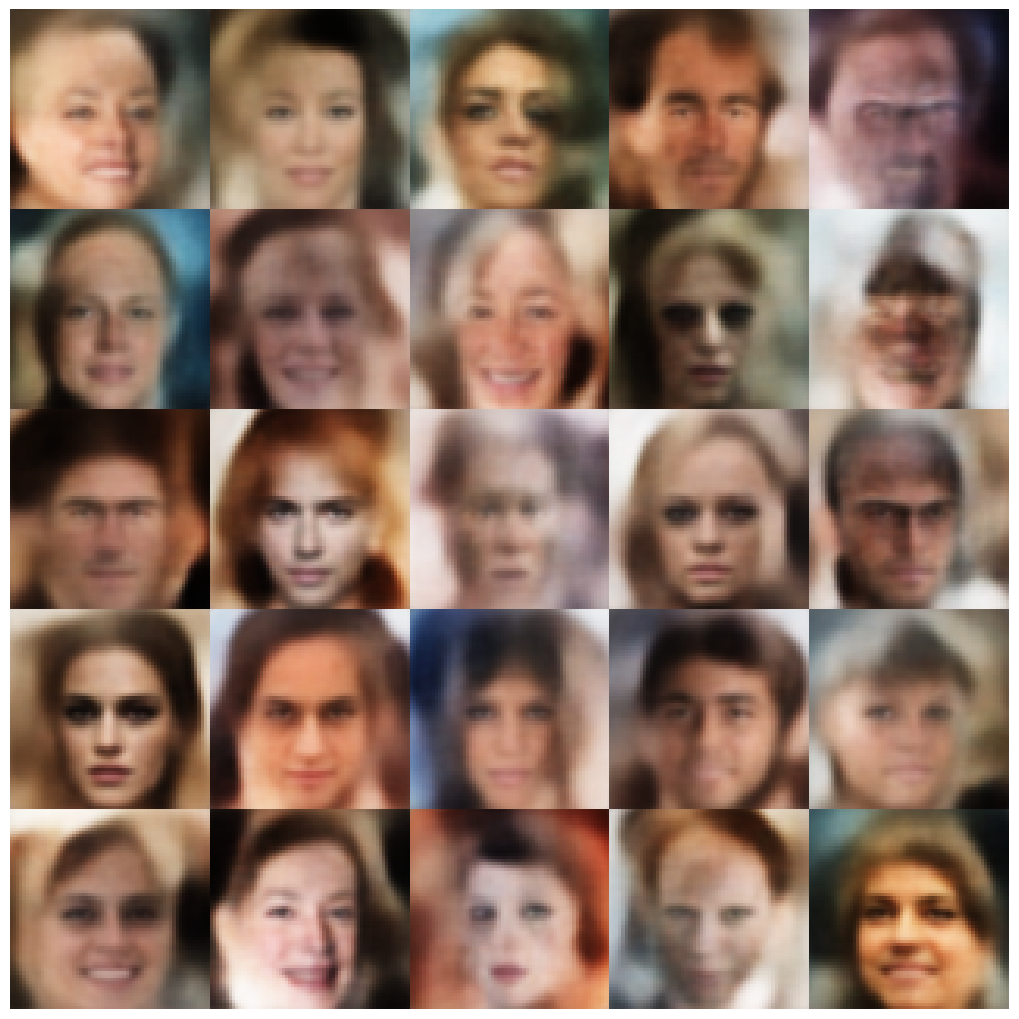

In [11]:
import matplotlib.pyplot as plt

with torch.no_grad():
    gen_data = normal_sampler.sample(
        num_samples=25
    )

fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(10, 10))

for i in range(5):
    for j in range(5):
        if DATASET_NAME == "mnist":
            axes[i][j].imshow(gen_data[i*5 +j].cpu().reshape(28, 28), cmap='gray')
        elif DATASET_NAME == "celeba":
            axes[i][j].imshow(gen_data[i*5 +j].cpu().reshape(3, 64, 64).moveaxis(0, 2))
        elif DATASET_NAME == "cifar10":
            axes[i][j].imshow(gen_data[i*5 +j].cpu().reshape(3, 32, 32).moveaxis(0, 2))
        axes[i][j].axis('off')
plt.tight_layout(pad=0.)

## Metrics

In [12]:
with torch.no_grad():
    gen_data = normal_sampler.sample(
        num_samples=10000
    )
# inception needs 3 channels
if DATASET_NAME == "mnist":
    gen_data = gen_data.repeat(1, 3, 1, 1).cpu().detach().numpy() * 255.
    test_data = val_set.repeat(1, 3, 1, 1) * 255
elif DATASET_NAME == "celeba":
    test_data = val_set.reshape(-1, 3, 64, 64)*255.
    gen_data = gen_data.cpu().detach().numpy() * 255.
elif DATASET_NAME == "cifar10":
    test_data = val_set.reshape(-1, 3, 32, 32)*255.
    gen_data = gen_data.cpu().detach().numpy() * 255.
    
np.save(f"pythae_benchmarks/images_generated_{random_hex}", gen_data)
np.save(f"pythae_benchmarks/images_test_{DATASET_NAME}", test_data.numpy())

In [13]:
from fid import calculate_fid_given_paths
import os

fid_normal = calculate_fid_given_paths((f"pythae_benchmarks/images_generated_{random_hex}.npy", f"pythae_benchmarks/images_test_{DATASET_NAME}.npy"), None)

2023-06-14 17:12:45.306945: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-14 17:12:46.994821: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-06-14 17:12:46.995102: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-06-14 17:12:46.995116: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [14]:
from IS import get_inception_score
IS_mean_normal, IS_std_normal = get_inception_score([im for im in gen_data.swapaxes(1, 2).swapaxes(2, 3)])

Instructions for updating:
non-resource variables are not supported in the long term
Instructions for updating:
Use tf.gfile.GFile.


In [15]:
print(f"{DATASET_NAME.upper()} FID: {fid_normal}")

CELEBA FID: 70.29053440445355


In [16]:
print(f"{DATASET_NAME.upper()} IS: {IS_mean_normal} +- {IS_std_normal}")

CELEBA IS: 1.9424844980239868 +- 0.034229155629873276


# GMM Sampler

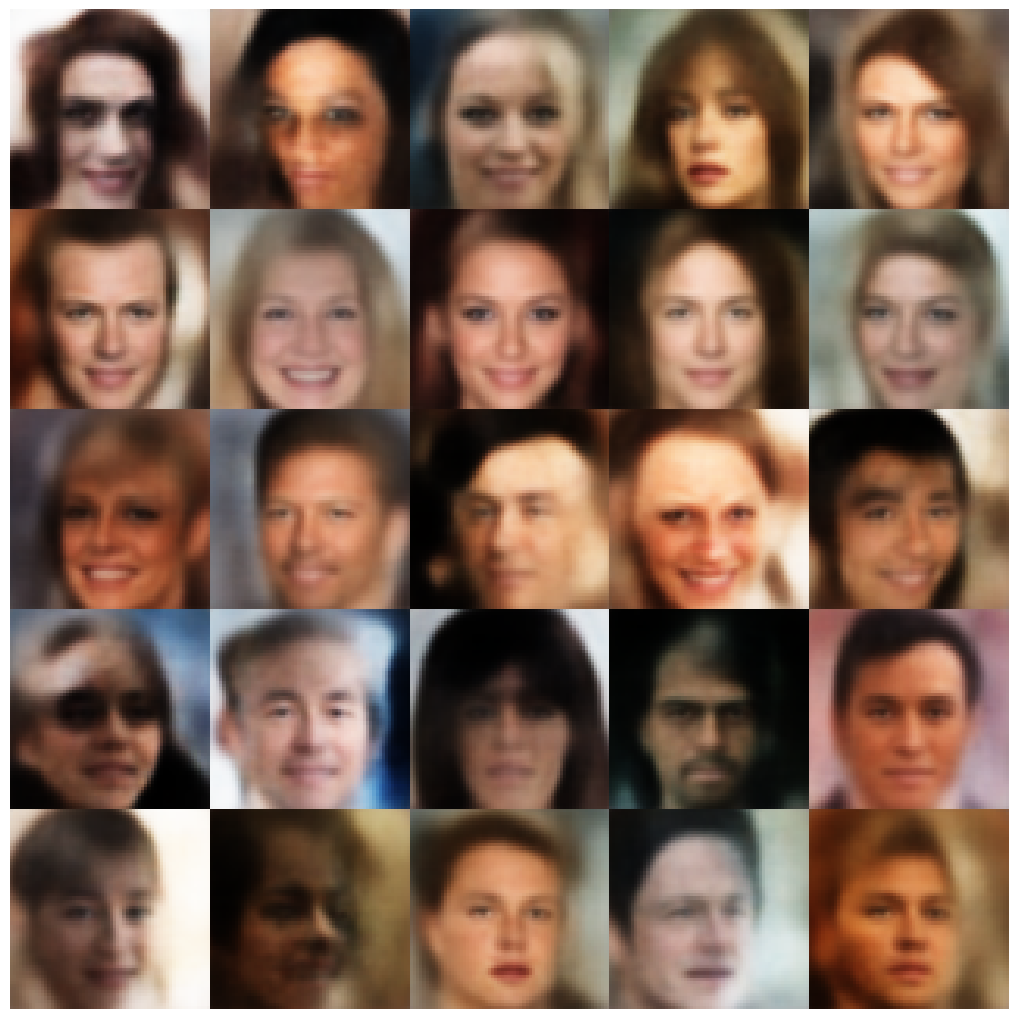

In [17]:
import matplotlib.pyplot as plt

with torch.no_grad():
    gen_data = gmm_sampler.sample(
        num_samples=25
    )

fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(10, 10))

for i in range(5):
    for j in range(5):
        if DATASET_NAME == "mnist":
            axes[i][j].imshow(gen_data[i*5 +j].cpu().reshape(28, 28), cmap='gray')
        elif DATASET_NAME == "celeba":
            axes[i][j].imshow(gen_data[i*5 +j].cpu().reshape(3, 64, 64).moveaxis(0, 2))
        elif DATASET_NAME == "cifar10":
            axes[i][j].imshow(gen_data[i*5 +j].cpu().reshape(3, 32, 32).moveaxis(0, 2))
        axes[i][j].axis('off')
plt.tight_layout(pad=0.)

## Metrics

In [18]:
with torch.no_grad():
    gen_data = gmm_sampler.sample(
        num_samples=10000
    )
# inception needs 3 channels
if DATASET_NAME == "mnist":
    gen_data = gen_data.repeat(1, 3, 1, 1).cpu().detach().numpy() * 255.
elif DATASET_NAME == "celeba":
    gen_data = gen_data.cpu().detach().numpy() * 255.
elif DATASET_NAME == "cifar10":
    gen_data = gen_data.cpu().detach().numpy() * 255.
    
np.save(f"pythae_benchmarks/images_generated_gmm_{random_hex}", gen_data)


In [19]:
from fid import calculate_fid_given_paths
import os

fid_gmm = calculate_fid_given_paths((f"pythae_benchmarks/images_generated_gmm_{random_hex}.npy", f"pythae_benchmarks/images_test_{DATASET_NAME}.npy"), None)

Calculating activations...: 100%|█████████████| 397/397 [00:48<00:00,  8.25it/s]


In [20]:
from IS import get_inception_score
IS_mean_gmm, IS_std_gmm = get_inception_score([im for im in gen_data.swapaxes(1, 2).swapaxes(2, 3)])

In [21]:
print(f"{DATASET_NAME.upper()} FID: {fid_gmm}")

CELEBA FID: 56.0527225315671


In [22]:
print(f"{DATASET_NAME.upper()} IS: {IS_mean_gmm} +- {IS_std_gmm}")

CELEBA IS: 1.7791271209716797 +- 0.023243164643645287


In [23]:
with open('pythae_benchmarks/results.txt', 'a') as f:
    f.write(f"Model {model_dir.split('/')[-1]} |" 
            + f" FID Normal Sampler {fid_normal:.2f} |" 
            + f" IS Normal Sampler {IS_mean_normal:.2f} |" 
            + f" FID GMM Sampler {fid_gmm:.2f} |" 
            + f" IS GMM Sampler {IS_mean_gmm:.2f} |")